# Exploratory Data Analysis 

We want to look at the relationship between Cognitive Function (Fine, MCI, AD) and the underlying Pathology (AD vs no AD). 

## Loading the Data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter, defaultdict
from importlib import reload
import seaborn as sns
from tabulate import tabulate
import sidetable as stb
import os, sys

sys.path.append(os.path.join("../", "utils"))
import load_data

In [2]:
reload(load_data)
uds = load_data.load_uds()
mri = load_data.load_mri()
csf = load_data.load_csf()
csf = csf.drop(['CSFTTYR', 'CSFLPMO', 'CSFLPDY', 'CSFABMO', 'CSFABDY', 'CSFABYR',
                'CSFPTMO', 'CSFPTDY', 'CSFPTYR', 'CSFTTMO', 'CSFTTDY', 'CSFTTYR', 'CSFLPYR',
                'CSFTTMDX','CSFABMDX', 'CSFPTMDX'], axis=1)
uds_dict, mri_dict = load_data.load_feature_map()
print(uds.shape, mri.shape, csf.shape)

(45100, 94) (11273, 172) (3017, 8)


#### Recode data so that we can easily see proportion of men vs women

In [57]:
def binary_sex(series):
    if series  == 1:
        return 0
    elif series == 2:
        return 1

uds['SEX_BIN'] = uds['SEX'].apply(binary_sex)
uds['SEX_BIN'].value_counts(sort=False)

0    19349
1    25751
Name: SEX_BIN, dtype: int64

In [58]:
uds['SEX'].value_counts(sort=False)

1    19349
2    25751
Name: SEX, dtype: int64

## EDA before we impute the missing data

UDSD:
1 = Normal cognition 
2 = Impaired-not-MCI 
3 = MCI 
4 = Dementia


ALZP:
1 = Primary
2 = Contributing
3 = Non-contributing
7 = Cognitively impaired but not AD diagnosis
8 = Diagnosis of normal cognition



In [37]:
pd.crosstab( uds.NACCALZP, uds.NACCUDSD, 
            #rownames=['Primary', 'Contributing', 'Non-Cont', 'Not AD', 'Normal Cog','Total'], 
            #colnames=['Normal', 'Impaired not MCI', 'MCI', 'Dementia','Total'],
            margins=True)

NACCUDSD,1,2,3,4,All
NACCALZP,,,,,
1,0,332,4255,11288,15875
2,0,40,236,714,990
3,0,0,4,5,9
7,0,1621,5357,3476,10454
8,17772,0,0,0,17772
All,17772,1993,9852,15483,45100


In [45]:
pd.crosstab( uds.NACCALZP, uds.NACCUDSD, 
            #rownames=['Primary', 'Contributing', 'Non-Cont', 'Not AD', 'Normal Cog','Total'], 
            #colnames=['Normal', 'Impaired not MCI', 'MCI', 'Dementia','Total'],
            values = uds['NACCAGE'],
            aggfunc = 'mean',
            margins=True).round(2)

NACCUDSD,1,2,3,4,All
NACCALZP,,,,,
1,NaN,73.35,73.41,74.21,73.98
2,NaN,72.58,73.38,71.93,72.30
3,NaN,NaN,69.00,73.60,71.56
7,NaN,69.37,72.11,67.13,70.03
8,70.14,NaN,NaN,NaN,70.14
All,70.14,70.09,72.70,72.52,71.51


In [46]:
pd.crosstab( uds.NACCALZP, uds.NACCUDSD, 
            #rownames=['Primary', 'Contributing', 'Non-Cont', 'Not AD', 'Normal Cog','Total'], 
            #colnames=['Normal', 'Impaired not MCI', 'MCI', 'Dementia','Total'],
            values = uds['EDUC'],
            aggfunc = 'mean',
            margins=True).round(2)

NACCUDSD,1,2,3,4,All
NACCALZP,,,,,
1,NaN,16.07,15.60,14.18,14.60
2,NaN,14.65,14.96,14.61,14.70
3,NaN,NaN,16.50,17.50,17.00
7,NaN,14.48,14.91,15.06,14.89
8,15.79,NaN,NaN,NaN,15.79
All,15.79,14.75,15.21,14.39,15.14


In [60]:
pd.crosstab( uds.NACCALZP, uds.NACCUDSD, 
            #rownames=['Primary', 'Contributing', 'Non-Cont', 'Not AD', 'Normal Cog','Total'], 
            #colnames=['Normal', 'Impaired not MCI', 'MCI', 'Dementia','Total'],
            values = uds['SEX_BIN'],
            aggfunc = 'mean',
            margins=True).round(2)

NACCUDSD,1,2,3,4,All
NACCALZP,,,,,
1,NaN,0.55,0.50,0.56,0.55
2,NaN,0.48,0.51,0.44,0.46
3,NaN,NaN,0.50,0.20,0.33
7,NaN,0.58,0.50,0.40,0.48
8,0.65,NaN,NaN,NaN,0.65
All,0.65,0.58,0.50,0.52,0.57


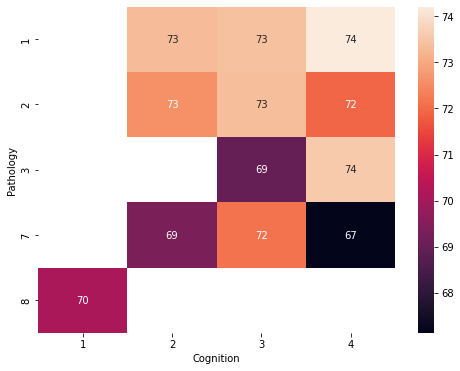

In [64]:
plt.figure(figsize=(8, 6))
sns.heatmap(
    pd.crosstab( uds.NACCALZP, uds.NACCUDSD, 
            colnames=['Cognition'], 
            rownames=['Pathology'],
            values = uds['NACCAGE'],
            aggfunc = 'mean',
            margins=False).round(2), 
    annot = True
)
plt.show()

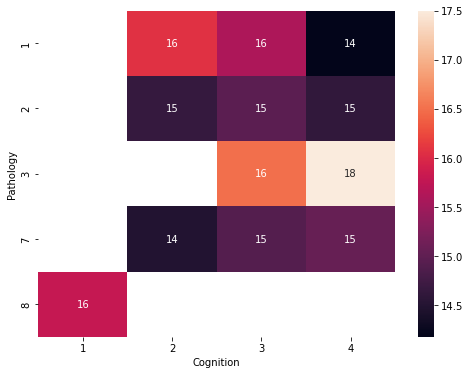

In [63]:
plt.figure(figsize=(8, 6))
sns.heatmap(
    pd.crosstab( uds.NACCALZP, uds.NACCUDSD, 
            colnames=['Cognition'], 
            rownames=['Pathology'],
            values = uds['EDUC'],
            aggfunc = 'mean',
            margins=False).round(2), 
    annot = True
)
plt.show()

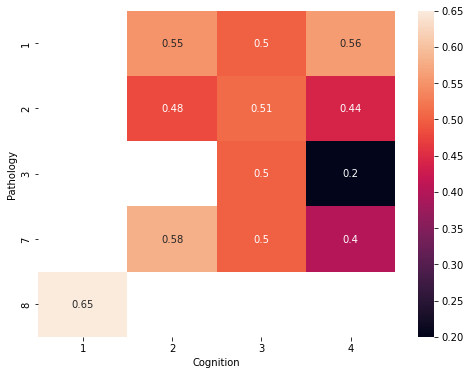

In [62]:
plt.figure(figsize=(8, 6))
sns.heatmap(
    pd.crosstab( uds.NACCALZP, uds.NACCUDSD, 
            colnames=['Cognition'], 
            rownames=['Pathology'],
            values = uds['SEX_BIN'],
            aggfunc = 'mean',
            margins=False).round(2), 
    annot = True
)
plt.show()

In [26]:
#uds[['NACCALZP',"EDUC","NACCAGE"  ]].groupby('NACCALZP').mean()

uds['NACCAGE'].mean()

71.51168514412417

## Impute missing 

We use the random forest for UDS and MRI and we use mean/ mode imputation for CSF. 

In [13]:
uds.stb.missing()

,missing,total,percent
ELATSEV,43620,45100,96.718404
HALLSEV,43170,45100,95.720621
DELSEV,41895,45100,92.893570
MOTSEV,40294,45100,89.343681
DISNSEV,39664,45100,87.946785
...,...,...,...
NACCUDSD,0,45100,0.000000
SEX,0,45100,0.000000
NACCVNUM,0,45100,0.000000
NACCAGE,0,45100,0.000000
